# **Pretrain a TF model to imitate federated learning**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-01-15 14:30:29.260295: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-15 14:30:29.839093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
RESULTS_ROOT = "../01_simulation/04_results/"
SEEDS = ['42', '1234', '1867', '613', '1001']

In [4]:
p_data = pd.DataFrame()
#READING DATA:
for s in SEEDS:
    filename = RESULTS_ROOT+f'poccup_by_vehs_{s}.csv'
    pf = pd.read_csv(filename)
    pf["seed"] = [s]*len(pf)
    p_data = pd.concat([p_data, pf])
    
p_data = pd.get_dummies(p_data, columns=["parking_id"])
p_data["time"] = p_data["time"] - 4*24*60*60
p_data["time"] = p_data["time"].astype(int)
p_data["time_of_day"] = (p_data["time"] - (p_data["time"] // (24*60*60))*24*60*60) / (24*60*60) #converting to 0.0-1.0 and removing periodicity

## Create vehicle list

In [10]:
vehicles = np.random.choice(p_data["veh_id"].unique(), 5000) #out of 9819 vehicles
test_vehicles = np.random.choice(p_data[~p_data["veh_id"].isin(vehicles)]["veh_id"].unique(), 300)

In [13]:
# save the list of selected vehicles:
import json

save_vehs = {
    "train_vehs": list(vehicles),
    "test_vehs" : list(test_vehicles)
}
with open("veh_list.json", "w") as f:
    json.dump(save_vehs, f)

## Load vehicle list

In [5]:
#loading the list selected vehicles:
import json

with open("veh_list.json", "r") as f:
    saved_vehs = json.load(f)
vehicles = saved_vehs["train_vehs"]

## Training

In [6]:
p_train = p_data[p_data["veh_id"].isin(vehicles)]

In [7]:
#p_train = p_train[p_train["time"] < 3*24*60*60]

In [34]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.001))
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)]

In [35]:
X_train = p_train.drop(columns=["veh_id", "time", "occupancy", "seed"])
y_train = p_train["occupancy"]

In [36]:
train_indices = np.random.randint(0, len(X_train), 1000000)
x_train_batch = X_train.iloc[train_indices]
y_train_batch = y_train.iloc[train_indices]
history = model.fit(x=x_train_batch, y=y_train_batch, epochs=5, batch_size=10000, callbacks=callbacks)
while len(history.history["loss"])%5 == 0:
    history = model.fit(x=x_train_batch, y=y_train_batch, epochs=5, batch_size=10000, callbacks=callbacks)

Epoch 1/5
100/100 [==============================] - 1s 4ms/step - loss: 0.0675
Epoch 2/5
100/100 [==============================] - 0s 5ms/step - loss: 0.0301
Epoch 3/5
100/100 [==============================] - 0s 5ms/step - loss: 0.0148
Epoch 4/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0074
Epoch 5/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 1/5
100/100 [==============================] - 0s 5ms/step - loss: 0.0038
Epoch 2/5
100/100 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 3/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 4/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 5/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 1/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 2/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 3/5
100/100 [=====================

## **Checking**

In [37]:
p_data

,veh_id,time,occupancy,seed,parking_id_pa-109,parking_id_pa-11,parking_id_pa-120,parking_id_pa-123,parking_id_pa-131,parking_id_pa-144,...,parking_id_pa55,parking_id_pa58,parking_id_pa60,parking_id_pa64,parking_id_pa68,parking_id_pa71,parking_id_pa75,parking_id_pa79,parking_id_pa92,time_of_day
0,h3098c1:0,10,0.923077,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000116
1,h3098c1:0,10,0.842105,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000116
2,h3098c1:0,10,0.769231,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000116
3,h3098c1:0,11,0.923077,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000127
4,h3098c1:0,11,0.842105,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3128768,h798c1:0,432000,0.000000,1001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3128769,h798c1:0,432000,0.750000,1001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3128770,h3101c1:0,432000,0.428571,1001,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3128771,h3101c1:0,432000,0.000000,1001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [38]:
#PARKING = "pa184"
PARKING = "pa-71"

In [39]:
parking_data = p_data[p_data[f"parking_id_{PARKING}"] == 1]
vis_data = parking_data.groupby("time_of_day")["occupancy"].mean()

In [40]:
t = np.arange(0, 1, 1/(24*60*60))

In [41]:
one_hot = parking_data.drop(columns=["veh_id", "time", "occupancy", "seed", "time_of_day"]).iloc[0]
one_hot = [one_hot.values]*len(t)

In [42]:
pred_x = np.array(one_hot)

In [43]:
pred_x = pd.DataFrame(pred_x)
pred_x["t"] = t

In [44]:
preds = model.predict(pred_x, batch_size=200)

432/432 [==============================] - 0s 702us/step


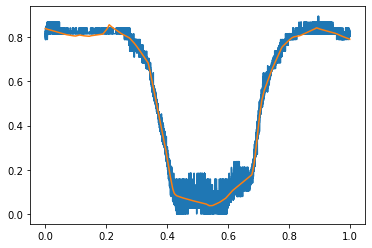

In [45]:
plt.plot(vis_data)
plt.plot(t, preds)

In [46]:
model.save("saved_models/pretrained")

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(79, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff155d7ac0>, 139634964754304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(79, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff155d7ac0>, 139634964754304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff155f2e20>, 139634964753904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff155f2e20>, 139634964753904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff1559d0a0>, 139636166310368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff1559d0a0>, 139636166310368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff154c6250>, 139636166309168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff154c6250>, 139636166309168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff152a95e0>, 139634964712144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff152a95e0>, 139634964712144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff1490afa0>, 139634964710464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff1490afa0>, 139634964710464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff15ef9a60>, 139634964710224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff15ef9a60>, 139634964710224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff15eda400>, 139634964712224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff15eda400>, 139634964712224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(79, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff155d7ac0>, 139634964754304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(79, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff155d7ac0>, 139634964754304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff155f2e20>, 139634964753904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff155f2e20>, 139634964753904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff1559d0a0>, 139636166310368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff1559d0a0>, 139636166310368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff154c6250>, 139636166309168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff154c6250>, 139636166309168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff152a95e0>, 139634964712144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff152a95e0>, 139634964712144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff1490afa0>, 139634964710464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff1490afa0>, 139634964710464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff15ef9a60>, 139634964710224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff15ef9a60>, 139634964710224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff15eda400>, 139634964712224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7eff15eda400>, 139634964712224), {}).


INFO:tensorflow:Assets written to: saved_models/pretrained/assets


INFO:tensorflow:Assets written to: saved_models/pretrained/assets
